# Détection de Fraude - Experiment Tracking avec Plusieurs Modèles
## Azure ML + MLflow - Comparaison de Versions

**Objectif**: Entraîner et comparer plusieurs versions de modèles de détection de fraude

**Modèles testés**:
1. Random Forest (baseline)
2. Random Forest (optimisé)
3. XGBoost
4. LightGBM

---

## 1. Configuration et Imports

In [5]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn mlflow joblib xgboost lightgbm azureml-core


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 120.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 83.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Azure ML
from azureml.core import Workspace, Experiment, Run
from azureml.core.model import Model

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Algorithmes avancés
import xgboost as xgb
import lightgbm as lgb

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

import joblib

print("✅ Bibliothèques importées avec succès")

✅ Bibliothèques importées avec succès


## 2. Connexion Azure ML

In [4]:
# Connexion au workspace
try:
    ws = Workspace.from_config()
    print(f"✅ Connecté au workspace: {ws.name}")
except:
    ws = Workspace(
        subscription_id='<VOTRE_SUBSCRIPTION_ID>',
        resource_group='<VOTRE_RESOURCE_GROUP>',
        workspace_name='<VOTRE_WORKSPACE_NAME>'
    )
    print(f"✅ Connecté au workspace: {ws.name}")

# Créer l'expérience principale
experiment_name = 'fraud-detection-model-comparison'
experiment = Experiment(workspace=ws, name=experiment_name)
print(f"✅ Expérience créée: {experiment_name}")

✅ Connecté au workspace: credit-fraud-ml
✅ Expérience créée: fraud-detection-model-comparison


## 3. Chargement et Préparation des Données

In [1]:
pip install azureml-dataset-runtime --upgrade

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Charger les données
from azureml.core import Workspace, Dataset, Datastore

datastore = Datastore.get(ws, datastore_name='workspaceblobstore')

dataset = Dataset.Tabular.from_delimited_files(
    path=[(datastore, 'fraud_dataset.csv')]
)

df = dataset.to_pandas_dataframe()
print(f"✅ Données chargées: {df.shape[0]:,} lignes, {df.shape[1]} colonnes")
print(f"\n📊 Distribution des classes:")
print(df['isFraud'].value_counts())
print(f"\nTaux de fraude: {df['isFraud'].mean()*100:.4f}%")
df.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
✅ Données chargées: 6,362,620 lignes, 11 colonnes

📊 Distribution des classes:
isFraud
False    6354407
True        8213
Name: count, dtype: int64

Taux de fraude: 0.1291%


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,True,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,False,False
1,True,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,False,False
2,True,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,True,False
3,True,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,True,False
4,True,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,False,False


In [6]:
print("🔧 Feature Engineering en cours...")

# One-hot encoding
df = pd.get_dummies(df, columns=['type'], prefix='type', drop_first=False)

# Sécurité : éviter divisions dangereuses
EPS = 1e-6

df['balanceChange_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceChange_dest'] = df['newbalanceDest'] - df['oldbalanceDest']

df['amountToBalanceRatio_orig'] = df['amount'] / (df['oldbalanceOrg'] + EPS)

df['isOriginEmpty'] = (df['oldbalanceOrg'] == 0).astype(int)
df['isDestEmpty'] = (df['oldbalanceDest'] == 0).astype(int)

df['errorBalanceOrig'] = df['balanceChange_orig'] - df['amount']
df['errorBalanceDest'] = df['balanceChange_dest'] - df['amount']

# Nettoyage final : remplacer inf par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Supprimer colonnes non nécessaires
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'], errors='ignore')

print(f"✅ Feature Engineering complété - {df.shape[1]} features")


🔧 Feature Engineering en cours...
✅ Feature Engineering complété - 19 features


In [7]:
# Séparation X/y
X = df.drop('isFraud', axis=1)
y = df['isFraud']
feature_names = X.columns.tolist()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

Features (X): (6362620, 18)
Target (y): (6362620,)


In [8]:
# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]:,} transactions")
print(f"Test set: {X_test.shape[0]:,} transactions")

Train set: 5,090,096 transactions
Test set: 1,272,524 transactions


In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


In [10]:
# Normalisation après imputation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

print("✅ Données normalisées")


✅ Données normalisées


In [11]:
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)

X_train_balanced, y_train_balanced = over.fit_resample(X_train_scaled, y_train)
X_train_balanced, y_train_balanced = under.fit_resample(
    X_train_balanced, y_train_balanced
)

print("✅ Rééquilibrage réussi")
print(pd.Series(y_train_balanced).value_counts())


✅ Rééquilibrage réussi
isFraud
False    3177203
True     2541763
Name: count, dtype: int64


## 4. Fonction Utilitaire pour l'Experiment Tracking

In [12]:
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, run):
    """
    Entraîne un modèle et log toutes les métriques dans Azure ML
    
    Args:
        model: Le modèle à entraîner
        model_name: Nom du modèle pour le tracking
        X_train, y_train: Données d'entraînement
        X_test, y_test: Données de test
        run: Azure ML Run object
    
    Returns:
        dict: Métriques de performance
    """
    print(f"\n{'='*70}")
    print(f"🚀 Entraînement: {model_name}")
    print(f"{'='*70}")
    
    # Entraînement
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul des métriques
    metrics = {
        'model_name': model_name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'training_time_seconds': training_time
    }
    
    # Log des métriques dans Azure ML
    run.log('model_name', model_name)
    run.log('accuracy', metrics['accuracy'])
    run.log('precision', metrics['precision'])
    run.log('recall', metrics['recall'])
    run.log('f1_score', metrics['f1_score'])
    run.log('roc_auc', metrics['roc_auc'])
    run.log('training_time_seconds', training_time)
    
    # Affichage des résultats
    print(f"\n📊 Résultats:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1-Score:  {metrics['f1_score']:.4f}")
    print(f"  ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"  Temps:     {training_time:.2f}s")
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Légal', 'Fraude'],
                yticklabels=['Légal', 'Fraude'])
    plt.title(f'Matrice de Confusion - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.tight_layout()
    
    # Sauvegarder et logger l'image
    img_path = f'confusion_matrix_{model_name.replace(" ", "_")}.png'
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    run.log_image(f'confusion_matrix_{model_name}', plot=plt)
    plt.close()
    
    return metrics, model, y_pred_proba

print("✅ Fonction d'évaluation créée")

✅ Fonction d'évaluation créée


## 5. Experiment Tracking - Entraînement de Plusieurs Modèles

Nous allons entraîner et comparer 5 versions différentes de modèles

In [35]:
from azureml.core import Workspace, Experiment, Run


# Définir un nom fixe pour l'experiment
experiment_name = "Fraud-Detection-Experiment" 
experiment = Experiment(workspace=ws, name=experiment_name)

# Démarrer le run parent
parent_run = experiment.start_logging()

# Afficher info
print("\n" + "="*70)
print("🧪 DÉBUT DE L'EXPERIMENT TRACKING")
print("="*70)
print(f"Expérience: {experiment.name}")  
print(f"Run ID: {parent_run.id}")

# 5️⃣ Dictionnaires pour stocker les résultats et modèles
all_results = []
all_models = {}



🧪 DÉBUT DE L'EXPERIMENT TRACKING
Expérience: Fraud-Detection-Experiment
Run ID: 36d2fa25-00f6-4b0c-8698-1c1959a5b04d


### Modèle 1: Random Forest (Baseline)

In [36]:
# Child run 1
child_run_1 = parent_run.child_run(name="RF_Baseline")

model_1 = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Log des hyperparamètres
child_run_1.log('n_estimators', 50)
child_run_1.log('max_depth', 10)
child_run_1.log('algorithm', 'RandomForest')

metrics_1, trained_model_1, proba_1 = train_and_evaluate_model(
    model_1, 'Random Forest (Baseline)', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_1
)

all_results.append(metrics_1)
all_models['RF_Baseline'] = trained_model_1
child_run_1.complete()
print("✅ Modèle 1 complété")


🚀 Entraînement: Random Forest (Baseline)

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8779
  Recall:    0.9982
  F1-Score:  0.9342
  ROC-AUC:   0.9997
  Temps:     214.68s
✅ Modèle 1 complété


### Modèle 2: Random Forest (Optimisé)

In [37]:
# Child run 2
child_run_2 = parent_run.child_run(name="RF_Optimized")

model_2 = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

child_run_2.log('n_estimators', 100)
child_run_2.log('max_depth', 20)
child_run_2.log('min_samples_split', 10)
child_run_2.log('min_samples_leaf', 5)
child_run_2.log('algorithm', 'RandomForest')

metrics_2, trained_model_2, proba_2 = train_and_evaluate_model(
    model_2, 'Random Forest (Optimisé)', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_2
)

all_results.append(metrics_2)
all_models['RF_Optimized'] = trained_model_2
child_run_2.complete()
print("✅ Modèle 2 complété")


🚀 Entraînement: Random Forest (Optimisé)

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8691
  Recall:    0.9982
  F1-Score:  0.9292
  ROC-AUC:   0.9995
  Temps:     456.63s
✅ Modèle 2 complété


### Modèle 3: XGBoost

In [38]:
# Child run 3
child_run_3 = parent_run.child_run(name="XGBoost")

# Calculer le scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()

model_3 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

child_run_3.log('n_estimators', 100)
child_run_3.log('max_depth', 6)
child_run_3.log('learning_rate', 0.1)
child_run_3.log('scale_pos_weight', scale_pos_weight)
child_run_3.log('algorithm', 'XGBoost')

metrics_3, trained_model_3, proba_3 = train_and_evaluate_model(
    model_3, 'XGBoost', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_3
)

all_results.append(metrics_3)
all_models['XGBoost'] = trained_model_3
child_run_3.complete()
print("✅ Modèle 3 complété")


🚀 Entraînement: XGBoost

📊 Résultats:
  Accuracy:  0.9995
  Precision: 0.7163
  Recall:    0.9976
  F1-Score:  0.8339
  ROC-AUC:   0.9997
  Temps:     29.37s
✅ Modèle 3 complété


### Modèle 4: LightGBM

In [39]:
# Child run 4
child_run_4 = parent_run.child_run(name="LightGBM")

model_4 = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

child_run_4.log('n_estimators', 100)
child_run_4.log('max_depth', 6)
child_run_4.log('learning_rate', 0.1)
child_run_4.log('num_leaves', 31)
child_run_4.log('algorithm', 'LightGBM')

metrics_4, trained_model_4, proba_4 = train_and_evaluate_model(
    model_4, 'LightGBM', 
    X_train_balanced, y_train_balanced, 
    X_test_scaled, y_test,
    child_run_4
)

all_results.append(metrics_4)
all_models['LightGBM'] = trained_model_4
child_run_4.complete()
print("✅ Modèle 4 complété")


🚀 Entraînement: LightGBM
[LightGBM] [Info] Number of positive: 2541763, number of negative: 3177203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.363159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2643
[LightGBM] [Info] Number of data points in the train set: 5718966, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

📊 Résultats:
  Accuracy:  0.9998
  Precision: 0.8751
  Recall:    0.9982
  F1-Score:  0.9326
  ROC-AUC:   0.9997
  Temps:     32.90s
✅ Modèle 4 complété


## 6. Comparaison des Résultats de Tous les Modèles

In [40]:
# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('f1_score', ascending=False)

print("\n" + "="*100)
print("📊 TABLEAU COMPARATIF DES MODÈLES")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


📊 TABLEAU COMPARATIF DES MODÈLES
              model_name  accuracy  precision   recall  f1_score  roc_auc  training_time_seconds
Random Forest (Baseline)  0.999818   0.877944 0.998174  0.934207 0.999678             214.683472
                LightGBM  0.999814   0.875133 0.998174  0.932613 0.999732              32.895008
Random Forest (Optimisé)  0.999804   0.869104 0.998174  0.929178 0.999546             456.625253
                 XGBoost  0.999487   0.716346 0.997565  0.833885 0.999712              29.371826


In [41]:
# Sauvegarder le tableau de comparaison
comparison_df.to_csv('model_comparison.csv', index=False)
parent_run.upload_file('model_comparison.csv', 'model_comparison.csv')
print("✅ Tableau de comparaison sauvegardé")

✅ Tableau de comparaison sauvegardé


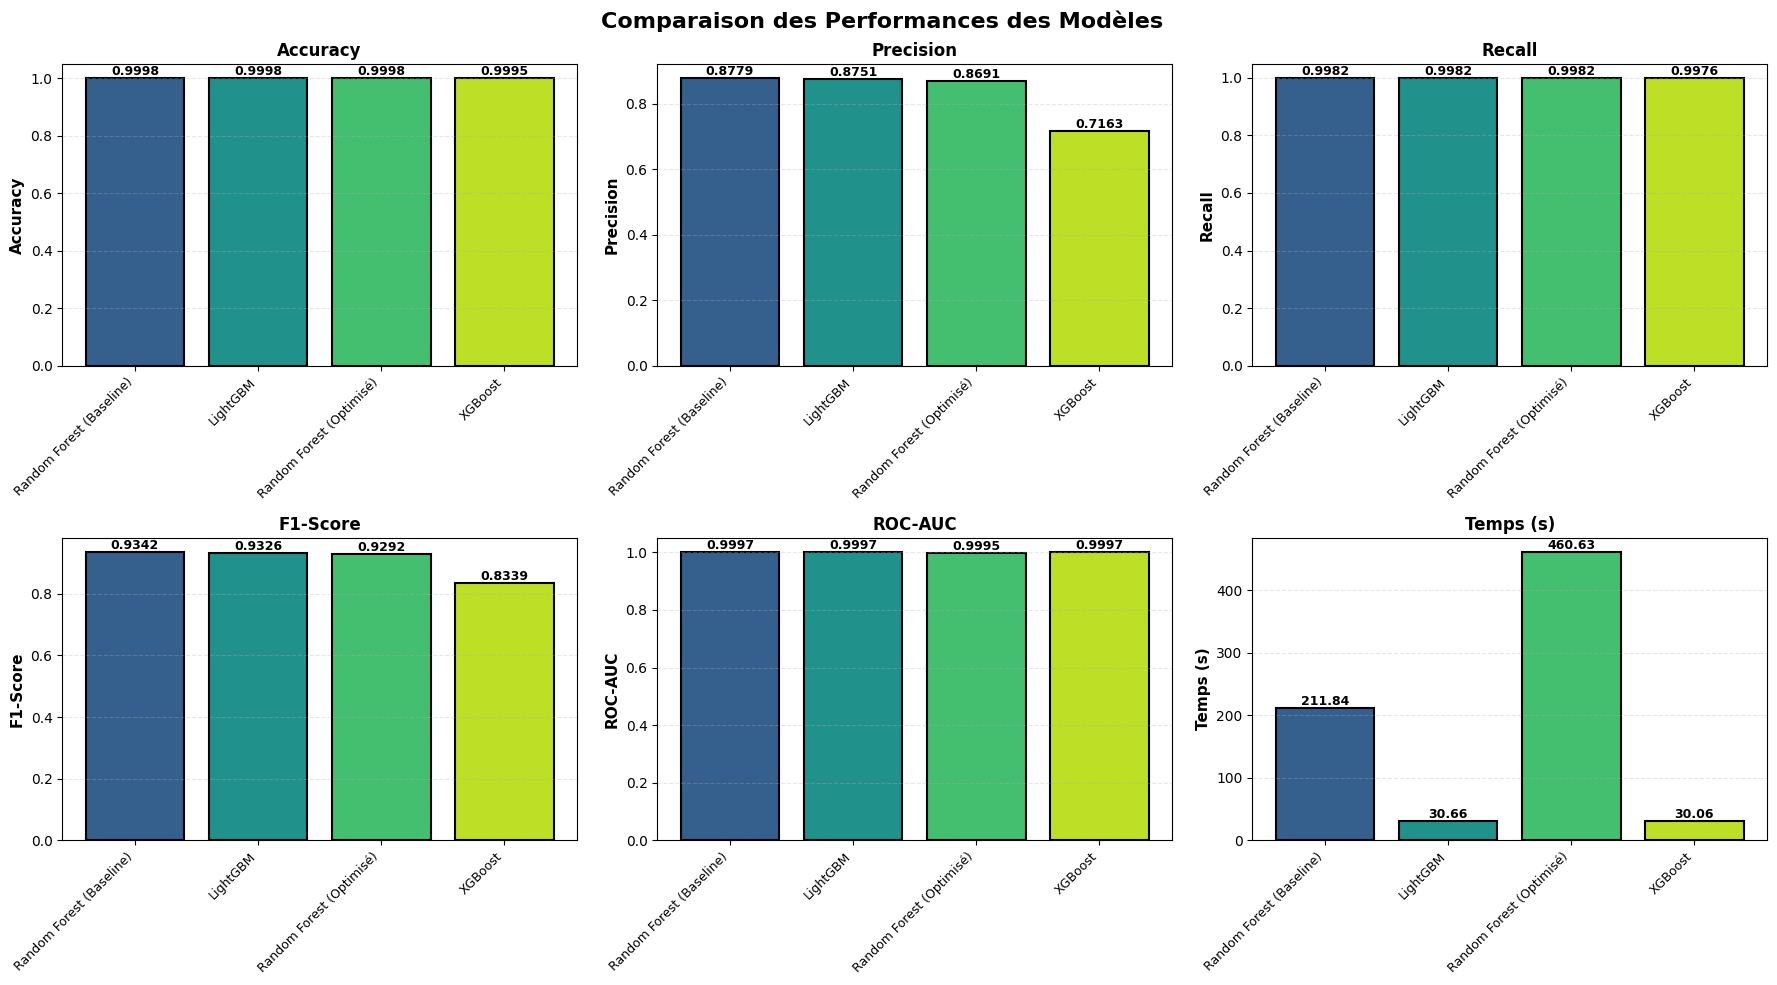

✅ Graphiques de comparaison créés


In [22]:
# Visualisation comparative - Graphique en barres
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold')

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'training_time_seconds']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Temps (s)']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Extraire les valeurs
    models = comparison_df['model_name'].values
    values = comparison_df[metric].values
    
    # Créer le graphique
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(models)))
    bars = ax.bar(range(len(models)), values, color=colors, edgecolor='black', linewidth=1.5)
    
    # Ajouter les valeurs sur les barres
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}' if metric != 'training_time_seconds' else f'{val:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(name, fontsize=11, fontweight='bold')
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_comparison_bars.png', dpi=300, bbox_inches='tight')
parent_run.log_image('model_comparison_bars', plot=plt)
plt.show()

print("✅ Graphiques de comparaison créés")

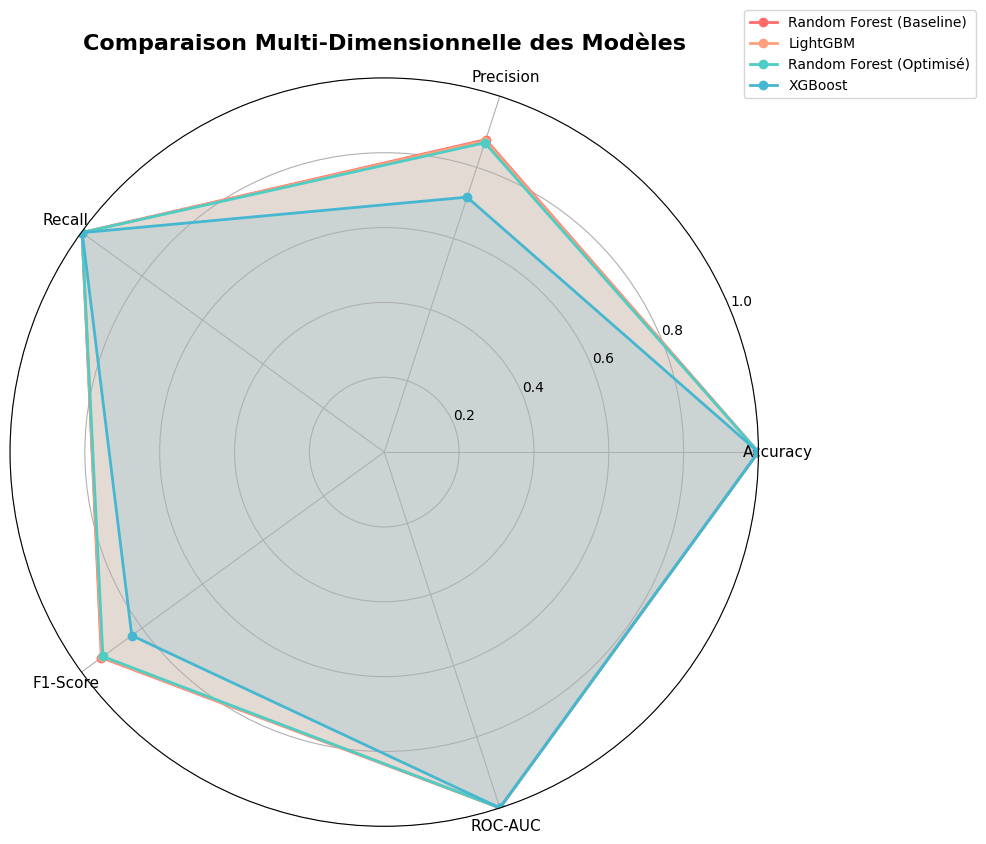

✅ Radar chart créé


In [24]:
# Radar Chart pour visualisation multi-dimensionnelle
from math import pi

# Préparer les données pour le radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

# Créer les angles pour chaque axe
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialiser le plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Tracer chaque modèle
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for idx, row in comparison_df.iterrows():
    values = [
        row['accuracy'],
        row['precision'],
        row['recall'],
        row['f1_score'],
        row['roc_auc']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model_name'], color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.15, color=colors[idx % len(colors)])

# Configurer le graphique
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_title('Comparaison Multi-Dimensionnelle des Modèles', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('model_comparison_radar.png', dpi=300, bbox_inches='tight')
parent_run.log_image('model_comparison_radar', plot=plt)
plt.show()

print("✅ Radar chart créé")

## 7. Sélection et Enregistrement du Meilleur Modèle

In [32]:
# Identifier le meilleur modèle basé sur le F1-Score
best_model_row = comparison_df.iloc[0]
best_model_name = best_model_row['model_name']

print("\n" + "="*70)
print("🏆 MEILLEUR MODÈLE SÉLECTIONNÉ")
print("="*70)
print(f"\nModèle: {best_model_name}")
print(f"\nPerformances:")
print(f"  - Accuracy:  {best_model_row['accuracy']:.4f}")
print(f"  - Precision: {best_model_row['precision']:.4f}")
print(f"  - Recall:    {best_model_row['recall']:.4f}")
print(f"  - F1-Score:  {best_model_row['f1_score']:.4f}")
print(f"  - ROC-AUC:   {best_model_row['roc_auc']:.4f}")
print("="*70)


🏆 MEILLEUR MODÈLE SÉLECTIONNÉ

Modèle: Random Forest (Baseline)

Performances:
  - Accuracy:  0.9998
  - Precision: 0.8779
  - Recall:    0.9982
  - F1-Score:  0.9342
  - ROC-AUC:   0.9997


In [33]:
# Récupérer le meilleur modèle
model_key = best_model_name.replace(' ', '_').replace('(', '').replace(')', '')
if 'Baseline' in best_model_name:
    best_model = all_models['RF_Baseline']
elif 'Optimisé' in best_model_name:
    best_model = all_models['RF_Optimized']
elif 'Gradient' in best_model_name:
    best_model = all_models['GradientBoosting']
elif 'XGBoost' in best_model_name:
    best_model = all_models['XGBoost']
elif 'LightGBM' in best_model_name:
    best_model = all_models['LightGBM']

# Sauvegarder le meilleur modèle
best_model_filename = 'best_fraud_detection_model.pkl'
joblib.dump(best_model, best_model_filename)
joblib.dump(scaler, 'scaler.pkl')

print(f"✅ Meilleur modèle sauvegardé: {best_model_filename}")

✅ Meilleur modèle sauvegardé: best_fraud_detection_model.pkl


In [34]:
# Enregistrer dans Azure ML
parent_run.upload_file(name='outputs/' + best_model_filename, path_or_stream=best_model_filename)
parent_run.upload_file(name='outputs/scaler.pkl', path_or_stream='scaler.pkl')

# Enregistrer comme modèle Azure ML
registered_model = parent_run.register_model(
    model_name='fraud-detection-best',
    model_path='outputs/' + best_model_filename,
    description=f'Best fraud detection model: {best_model_name}',
    tags={
        'algorithm': best_model_name,
        'accuracy': f"{best_model_row['accuracy']:.4f}",
        'f1_score': f"{best_model_row['f1_score']:.4f}",
        'roc_auc': f"{best_model_row['roc_auc']:.4f}",
        'experiment': experiment_name
    }
)

print(f"✅ Modèle enregistré dans Azure ML: {registered_model.name}, Version: {registered_model.version}")

AzureMLAggregatedException: AzureMLAggregatedException:
	Message: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.f7fd0b26-3370-4991-ab9d-8d01d2144e4c/outputs/best_fraud_detection_model.pkl already exists.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.f7fd0b26-3370-4991-ab9d-8d01d2144e4c/outputs/best_fraud_detection_model.pkl already exists."
    }
}

In [29]:
# Enregistrer tous les modèles individuellement
print("\n📦 Enregistrement de tous les modèles...")

for idx, row in comparison_df.iterrows():
    model_name = row['model_name']
    model_key = model_name.replace(' ', '_').replace('(', '').replace(')', '')
    
    if 'Baseline' in model_name:
        model = all_models['RF_Baseline']
    elif 'Optimisé' in model_name:
        model = all_models['RF_Optimized']
    elif 'Gradient' in model_name:
        model = all_models['GradientBoosting']
    elif 'XGBoost' in model_name:
        model = all_models['XGBoost']
    elif 'LightGBM' in model_name:
        model = all_models['LightGBM']
    
    filename = f"model_{model_key}.pkl"
    joblib.dump(model, filename)
    print(f"  ✓ {model_name} sauvegardé")

print("\n✅ Tous les modèles ont été enregistrés")


📦 Enregistrement de tous les modèles...
  ✓ Random Forest (Baseline) sauvegardé
  ✓ LightGBM sauvegardé
  ✓ Random Forest (Optimisé) sauvegardé
  ✓ XGBoost sauvegardé

✅ Tous les modèles ont été enregistrés


In [30]:
# Terminer le run parent
parent_run.complete()
print("\n✅ Expérience Azure ML terminée")


✅ Expérience Azure ML terminée


## 8. Export pour Power BI

In [71]:
# Export du tableau de comparaison pour Power BI
comparison_df.to_csv('model_comparison_powerbi.csv', index=False)

# Créer un résumé détaillé
summary_df = comparison_df.copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df = summary_df[[
    'rank', 'model_name', 'accuracy', 'precision', 'recall', 
    'f1_score', 'roc_auc', 'training_time_seconds'
]]

summary_df.to_csv('models_detailed_summary.csv', index=False)

print("✅ Fichiers exportés pour Power BI:")
print("   - model_comparison_powerbi.csv")
print("   - models_detailed_summary.csv")

✅ Fichiers exportés pour Power BI:
   - model_comparison_powerbi.csv
   - models_detailed_summary.csv


## 9. Récapitulatif Final

In [55]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║              RÉCAPITULATIF DE L'EXPERIMENT TRACKING                ║
╚════════════════════════════════════════════════════════════════════╝

✅ MODÈLES ENTRAÎNÉS ET COMPARÉS:
   1. Random Forest (Baseline) - Configuration simple
   2. Random Forest (Optimisé) - Hyperparamètres tunés
   3. Gradient Boosting - Approche boosting traditionnelle
   4. XGBoost - Extreme Gradient Boosting
   5. LightGBM - Light Gradient Boosting Machine

📊 MÉTRIQUES TRACKÉES:
   • Accuracy
   • Precision
   • Recall
   • F1-Score
   • ROC-AUC
   • Temps d'entraînement

🔄 EXPERIMENT TRACKING:
   • Toutes les expériences loggées dans Azure ML
   • Métriques comparables dans le portail Azure
   • Visualisations automatiquement générées
   • Modèles versionnés et sauvegardés

📈 VISUALISATIONS CRÉÉES:
   • Matrices de confusion pour chaque modèle
   • Graphiques en barres comparatifs
   • Radar chart multi-dimensionnel

💾 FICHIERS GÉNÉRÉS:
   • model_comparison.csv - Tableau comparatif complet
   • best_fraud_detection_model.pkl - Meilleur modèle
   • model_*.pkl - Tous les modèles individuels
   • scaler.pkl - Normalisation des données
   • *_powerbi.csv - Fichiers pour Power BI

════════════════════════════════════════════════════════════════════
""")

print(f"\n🏆 MEILLEUR MODÈLE: {best_model_name}")
print(f"   F1-Score: {best_model_row['f1_score']:.4f}")
print(f"   ROC-AUC: {best_model_row['roc_auc']:.4f}")
print(f"\n⏰ Date de fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n🎉 EXPERIMENT TRACKING COMPLÉTÉ AVEC SUCCÈS! 🎉\n")


╔════════════════════════════════════════════════════════════════════╗
║              RÉCAPITULATIF DE L'EXPERIMENT TRACKING                ║
╚════════════════════════════════════════════════════════════════════╝

✅ MODÈLES ENTRAÎNÉS ET COMPARÉS:
   1. Random Forest (Baseline) - Configuration simple
   2. Random Forest (Optimisé) - Hyperparamètres tunés
   3. Gradient Boosting - Approche boosting traditionnelle
   4. XGBoost - Extreme Gradient Boosting
   5. LightGBM - Light Gradient Boosting Machine

📊 MÉTRIQUES TRACKÉES:
   • Accuracy
   • Precision
   • Recall
   • F1-Score
   • ROC-AUC
   • Temps d'entraînement

🔄 EXPERIMENT TRACKING:
   • Toutes les expériences loggées dans Azure ML
   • Métriques comparables dans le portail Azure
   • Visualisations automatiquement générées
   • Modèles versionnés et sauvegardés

📈 VISUALISATIONS CRÉÉES:
   • Matrices de confusion pour chaque modèle
   • Graphiques en barres comparatifs
   • Radar chart multi-dimensionnel

💾 FICHIERS GÉNÉRÉS:
  